In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, linear
from keras.layers import Dense, Dropout, Conv1D, MaxPooling2D, Activation, Flatten, Embedding, Reshape,MaxPooling1D,LeakyReLU
!pip install yfinance
import yfinance as yf

/opt/conda/lib/python3.7/site-packages/botocore/httpsession.py:41: DeprecationWarning: 'urllib3.contrib.pyopenssl' module is deprecated and will be removed in a future release of urllib3 2.x. Read more in this issue: https://github.com/urllib3/urllib3/issues/2680
  from urllib3.contrib.pyopenssl import orig_util_SSLContext as SSLContext


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.5 MB/s eta 0:00:00


In [10]:
Crypto_name = ["BTC-USD"] # replace with other crypto currency e.g. "ETH-USD" 'XRP-USD' "LTC-USD"
start_date="2022-06-20"
end_date='2023-06-20'
closing_price=pd.DataFrame()
for i in Crypto_name:
    data= yf.Ticker(i)
    data = data.history(start=start_date , end=end_date,interval="1h")
    colse=pd.DataFrame(data.Close)
    closing_price[i] = colse

# Plot the closing changes 

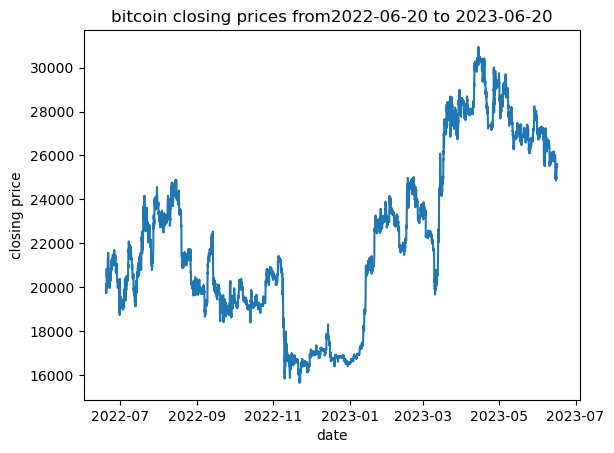

In [14]:
# plot the closing price changes in the given period
plt.xlabel("date")
plt.ylabel("closing price")
plt.title(f"bitcoin closing prices from{start_date} to {end_date}")
plt.plot(closing_price['BTC-USD'])


# Generate the action space

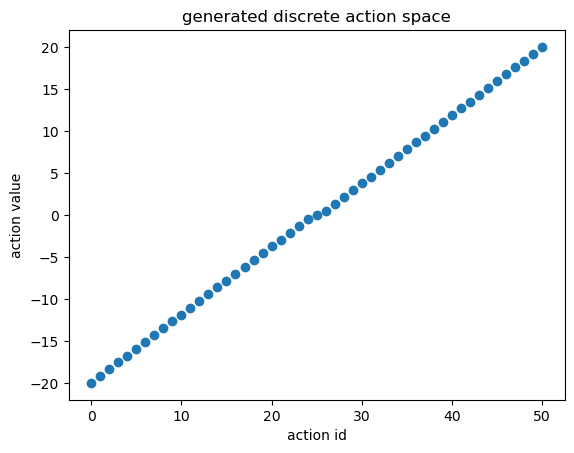

In [26]:
import gym
from gym import spaces
action_choices = np.linspace(0.5, 20, num=25) # using linespace to generate 25 actions to buy or sell in [0.5$,20$] interval
actions = []
actions.append(0.0) # add 0 choice to actions for hold
for act in action_choices:
    actions.append(act) # add positive number to buy x amount
    actions.append(-act) # add negative number to sell x amount
actions.sort()

plt.xlabel("action id")
plt.ylabel("action value")
plt.title(f"generated discrete action space")
plt.scatter([act for act in range(len(actions))],actions)